This code will load the model information, generate the model definition, and run the model estimation using FSL

In [1]:
# (broughton) conda activate nipype
# (broughton) python notebook --no-browser --port=8002
# (local terminal) ssh -N -L 8002:localhost:8002 vanessa.d@132.205.225.39 -p 8443
import nipype.algorithms.modelgen as model   # model generation
from  nipype.interfaces import fsl, ants      
from nipype.interfaces.base import Bunch
import os,json,glob,sys
import numpy
import nibabel
import nilearn.plotting
import pandas as pd


%matplotlib inline
import matplotlib.pyplot as plt

datadir='/home/data/refined/microbiome2brain/MRI/bids_dataset'
    
results_dir = os.path.abspath("output")
if not os.path.exists(results_dir):
    os.mkdir(results_dir)

from nipype.caching import Memory
mem = Memory(base_dir='.')

print('Using data from',datadir)

Using data from /home/data/refined/microbiome2brain/MRI/bids_dataset


/home/vanessa.d/anaconda3/envs/nipype/lib/python3.6/site-packages/nilearn/datasets/__init__.py:90: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  "Numpy arrays.", FutureWarning)


In [2]:
from nipype.interfaces.fsl import Info
Info.version()
from bids.grabbids import BIDSLayout
layout = BIDSLayout(datadir)

Failed to import duecredit due to No module named 'duecredit'
/home/vanessa.d/anaconda3/envs/nipype/lib/python3.6/site-packages/grabbit/core.py:410: UserWarning: No valid root directory found for domain 'derivatives'. Falling back on the Layout's root directory. If this isn't the intended behavior, make sure the config file for this domain includes a 'root' key.
  "'root' key." % config['name'])


In [3]:
events = pd.read_csv(os.path.join(datadir, "sub-E3/ses-01/func/sub-E3_ses-01_task-image_events.tsv"), sep="\t")
events

,onset,duration,trial_type
0,-7.923,4,Unhealthy
1,-3.923,4,Unhealthy
2,0.077,4,Unhealthy
3,4.077,4,Unhealthy
4,8.077,4,Unhealthy
...,...,...,...
103,507.100,4,Control
104,511.100,4,Control
105,515.100,4,Control
106,519.100,4,Control


In [4]:
events = pd.read_csv(os.path.join(datadir, "sub-E1/ses-01/func/sub-E1_ses-01_task-image_events.tsv"), sep="\t")
events

,onset,duration,trial_type
0,6.088,4,Unhealthy
1,10.088,4,Unhealthy
2,14.088,4,Unhealthy
3,18.088,4,Unhealthy
4,22.088,4,Unhealthy
...,...,...,...
103,520.861,4,Unhealthy
104,524.861,4,Unhealthy
105,528.861,4,Unhealthy
106,532.861,4,Unhealthy


In [19]:
for trial_type in events.trial_type.unique():
    print(events[events.trial_type == trial_type])

      onset  duration trial_type
0    -0.940         4    Healthy
1     3.060         4    Healthy
2     7.060         4    Healthy
3    11.060         4    Healthy
4    15.060         4    Healthy
6    29.061         4    Healthy
7    33.061         4    Healthy
8    37.061         4    Healthy
9    41.061         4    Healthy
10   45.061         4    Healthy
12   59.079         4    Healthy
13   63.079         4    Healthy
14   67.079         4    Healthy
15   71.079         4    Healthy
16   75.079         4    Healthy
60  299.824         4    Healthy
61  303.824         4    Healthy
62  307.824         4    Healthy
63  311.824         4    Healthy
64  315.824         4    Healthy
66  329.825         4    Healthy
67  333.825         4    Healthy
68  337.825         4    Healthy
69  341.825         4    Healthy
70  345.825         4    Healthy
90  449.897         4    Healthy
91  453.897         4    Healthy
92  457.897         4    Healthy
93  461.897         4    Healthy
94  465.89

In [20]:
events[events.trial_type == 'rest'].duration

5      10
11     10
17     10
23     10
29     10
35     10
41     10
47     10
53     10
59     10
65     10
71     10
77     10
83     10
89     10
95     10
101    10
107    10
Name: duration, dtype: int64

In [6]:
source_epi = layout.get(type="bold", task="image", session="01", extensions="nii.gz")[0]
source_epi.subject

'E1'

In [7]:
source_epi.session

'01'

In [8]:
source_epi = layout.get(type="bold", task="image", session="01", extensions="nii.gz")[3]

confounds = pd.read_csv(os.path.join(datadir, "derivatives", "fmriprep", 
                                        "sub-%s"%source_epi.subject, "ses-%s"%source_epi.session, "func", 
                                        "sub-%s_ses-%s_task-image_desc-confounds_timeseries.tsv"%(source_epi.subject, source_epi.session)),
           sep="\t", na_values="n/a")

events = pd.read_csv(os.path.join(datadir, "sub-%s"%source_epi.subject, "ses-%s"%source_epi.session, "func",
                                      "sub-%s_ses-%s_task-image_events.tsv"%(source_epi.subject, source_epi.session)),
                     sep="\t")


info = [Bunch(conditions=['Control',
                          'Healthy',
                          'Unhealthy'],
              onsets=[list(events[events.trial_type == 'Control'].onset-8),
                      list(events[events.trial_type == 'Healthy'].onset-8),
                      list(events[events.trial_type == 'Unhealthy'].onset-8),
                      list(events[events.trial_type == 'rest'].onset-8)],
              durations=[list(events[events.trial_type == 'Control'].duration),
                         list(events[events.trial_type == 'Healthy'].duration),
                         list(events[events.trial_type == 'Unhealthy'].duration),
                         list(events[events.trial_type == 'rest'].duration)],
             regressors=[list(confounds.framewise_displacement.fillna(0)),
                         list(confounds.a_comp_cor_00),
                         list(confounds.a_comp_cor_01),
                         list(confounds.a_comp_cor_02),
                         list(confounds.a_comp_cor_03),
                         list(confounds.a_comp_cor_04),
                         list(confounds.a_comp_cor_05),
                         list(confounds.non_steady_state_outlier00),
                         list(confounds.non_steady_state_outlier01),
                         list(confounds.non_steady_state_outlier02)
                        ],
             regressor_names=['framewise_displacement',
                              'a_comp_cor_00',
                              'a_comp_cor_01',
                              'a_comp_cor_02',
                              'a_comp_cor_03',
                              'a_comp_cor_04',
                              'a_comp_cor_05',
                              'non_steady_state_outlier00',
                              'non_steady_state_outlier01',
                              'non_steady_state_outlier02'])
       ]

skip = mem.cache(fsl.ExtractROI)
skip_results = skip(in_file=os.path.join(datadir, "derivatives", "fmriprep", 
                                        "sub-%s"%source_epi.subject, 
                                         "ses-%s"%source_epi.session,
                                         "func",
                                         "sub-%s_ses-%s_task-image_space-MNI152NLin2009cAsym_res-2_desc-preproc_bold.nii.gz"%(source_epi.subject,source_epi.session)),
                    t_min=4, t_size=-1)

s = model.SpecifyModel()
s.inputs.input_units = 'secs'
s.inputs.functional_runs = skip_results.outputs.roi_file
s.inputs.time_repetition = layout.get_metadata(source_epi.filename)["RepetitionTime"]
s.inputs.high_pass_filter_cutoff = 128.
s.inputs.subject_info = info
specify_model_results = s.run()
s.inputs

210517-16:13:23,548 nipype.workflow INFO:
	 [Node] Setting-up "0afcccc3c3d706b6e80b7615ad41b107" in "/home/vanessa.d/repositories/microbiome2brain/exp/exp21-postFmriprepAnalyses/nipype_mem/nipype-interfaces-fsl-utils-ExtractROI/0afcccc3c3d706b6e80b7615ad41b107".
210517-16:13:23,554 nipype.workflow INFO:
	 [Node] Cached "0afcccc3c3d706b6e80b7615ad41b107" - collecting precomputed outputs
210517-16:13:23,556 nipype.workflow INFO:
	 [Node] "0afcccc3c3d706b6e80b7615ad41b107" found cached.



bids_amplitude_column = <undefined>
bids_condition_column = trial_type
bids_event_file = <undefined>
event_files = <undefined>
functional_runs = ['/home/vanessa.d/repositories/microbiome2brain/exp/exp21-postFmriprepAnalyses/nipype_mem/nipype-interfaces-fsl-utils-ExtractROI/0afcccc3c3d706b6e80b7615ad41b107/sub-E4_ses-01_task-image_space-MNI152NLin2009cAsym_res-2_desc-preproc_bold_roi.nii.gz']
high_pass_filter_cutoff = 128.0
input_units = secs
outlier_files = <undefined>
parameter_source = SPM
realignment_parameters = <undefined>
subject_info = [Bunch(conditions=['Control', 'Healthy', 'Unhealthy'], durations=[[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4], [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4], [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4], [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10]], onsets=[[81.181, 85.181, 89.181, 

In [9]:
confounds = pd.read_csv(os.path.join(datadir, "derivatives", "fmriprep", 
                                        "sub-%s"%source_epi.subject, "ses-%s"%source_epi.session, "func", 
                                        "sub-%s_ses-%s_task-image_desc-confounds_timeseries.tsv"%(source_epi.subject, source_epi.session)),
           sep="\t", na_values="n/a")
confounds[3:]

,global_signal,global_signal_derivative1,global_signal_derivative1_power2,global_signal_power2,csf,csf_derivative1,csf_derivative1_power2,csf_power2,white_matter,white_matter_derivative1,...,rot_y_derivative1,rot_y_power2,rot_y_derivative1_power2,rot_z,rot_z_derivative1,rot_z_power2,rot_z_derivative1_power2,motion_outlier00,motion_outlier01,motion_outlier02
3,1382.500608,-14.971280,224.139226,1.911308e+06,1731.751259,-43.118741,1859.225859,2.998962e+06,1207.683578,-2.508773,...,0.000000,0.000000,0.000000e+00,-0.000075,-0.000074,5.576639e-09,5.547190e-09,0.0,0.0,0.0
4,1379.238719,-3.261889,10.639917,1.902299e+06,1723.659025,-8.092234,65.484251,2.971000e+06,1207.679754,-0.003824,...,0.000000,0.000000,0.000000e+00,-0.000014,0.000060,2.012256e-10,3.659222e-09,0.0,0.0,0.0
5,1376.689970,-2.548749,6.496122,1.895275e+06,1716.768783,-6.890242,47.475435,2.947295e+06,1206.966285,-0.713469,...,0.000000,0.000000,0.000000e+00,0.000019,0.000033,3.504084e-10,1.082713e-09,0.0,0.0,0.0
6,1377.357255,0.667285,0.445269,1.897113e+06,1714.602886,-2.165897,4.691110,2.939863e+06,1208.991021,2.024736,...,0.000000,0.000000,0.000000e+00,-0.000068,-0.000087,4.691318e-09,7.606003e-09,0.0,0.0,0.0
7,1376.467319,-0.889936,0.791987,1.894662e+06,1717.229864,2.626978,6.901013,2.948878e+06,1207.477726,-1.513294,...,0.000000,0.000000,0.000000e+00,0.000028,0.000097,8.077873e-10,9.392478e-09,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,1366.238710,0.186449,0.034763,1.866608e+06,1697.027697,3.524121,12.419427,2.879903e+06,1199.894686,-0.108343,...,-0.001855,0.000115,3.440060e-06,0.004368,0.000122,1.907672e-05,1.496952e-08,0.0,0.0,0.0
296,1364.562042,-1.676668,2.811216,1.862030e+06,1690.092448,-6.935249,48.097675,2.856412e+06,1199.114936,-0.779750,...,0.000543,0.000103,2.943063e-07,0.004854,0.000486,2.356151e-05,2.365169e-07,0.0,0.0,0.0
297,1365.347014,0.784972,0.616181,1.864172e+06,1695.559064,5.466616,29.883889,2.874921e+06,1198.320210,-0.794726,...,-0.001964,0.000147,3.855725e-06,0.005237,0.000383,2.742428e-05,1.465358e-07,0.0,0.0,0.0
298,1366.074001,0.726987,0.528511,1.866158e+06,1694.913469,-0.645595,0.416793,2.872732e+06,1198.038837,-0.281373,...,0.000457,0.000136,2.083923e-07,0.005578,0.000341,3.111107e-05,1.162196e-07,0.0,0.0,0.0


In [21]:
unhealthy_vs_rest = ["Unhealthy vs. rest",'T', ['rest', 'Unhealthy'],[-1, 1]]

control_cond = ['Control','T', ['Control'],[1]]
healthy_cond = ['Healthy','T', ['Healthy'],[1]]
unhealthy_cond = ['Unhealthy','T', ['Unhealthy'],[1]]
unhealthy_vs_others = ["Unhealthy vs. others",'T', ['Control', 'Healthy', 'Unhealthy'],[-0.5, -0.5, 1]]
unhealthy_vs_healthy = ["Unhealthy vs. healthy",'T', ['Healthy', 'Unhealthy'],[-1, 1]]
unhealthy_vs_control = ["Unhealthy vs. control",'T', ['Control', 'Unhealthy'],[-1, 1]]
healthy_vs_control = ["Healthy vs. control",'T', ['Control', 'Healthy'],[-1, 1]]

all_images = ["All images", 'F', [control_cond, healthy_cond, unhealthy_cond]]
contrasts=[unhealthy_vs_rest, control_cond, healthy_cond, unhealthy_cond, 
           unhealthy_vs_others, unhealthy_vs_healthy, unhealthy_vs_control, healthy_vs_control,
           all_images]
           
level1design = mem.cache(fsl.model.Level1Design)
level1design_results = level1design(interscan_interval = layout.get_metadata(source_epi.filename)["RepetitionTime"],
                                    bases = {'dgamma':{'derivs': True}},
                                    session_info = specify_model_results.outputs.session_info,
                                    model_serial_correlations=True,
                                    contrasts=contrasts)

level1design_results.outputs

210518-09:23:23,949 nipype.workflow INFO:
	 [Node] Setting-up "1b2e8a2f3ae2f426a35605792e6e85d0" in "/home/vanessa.d/repositories/microbiome2brain/exp/exp21-postFmriprepAnalyses/nipype_mem/nipype-interfaces-fsl-model-Level1Design/1b2e8a2f3ae2f426a35605792e6e85d0".
210518-09:23:24,38 nipype.workflow INFO:
	 [Node] Running "1b2e8a2f3ae2f426a35605792e6e85d0" ("nipype.interfaces.fsl.model.Level1Design")
210518-09:23:24,208 nipype.workflow INFO:
	 [Node] Finished "1b2e8a2f3ae2f426a35605792e6e85d0".



ev_files = ['/home/vanessa.d/repositories/microbiome2brain/exp/exp21-postFmriprepAnalyses/nipype_mem/nipype-interfaces-fsl-model-Level1Design/1b2e8a2f3ae2f426a35605792e6e85d0/ev_Control_0_1.txt', '/home/vanessa.d/repositories/microbiome2brain/exp/exp21-postFmriprepAnalyses/nipype_mem/nipype-interfaces-fsl-model-Level1Design/1b2e8a2f3ae2f426a35605792e6e85d0/ev_Healthy_0_3.txt', '/home/vanessa.d/repositories/microbiome2brain/exp/exp21-postFmriprepAnalyses/nipype_mem/nipype-interfaces-fsl-model-Level1Design/1b2e8a2f3ae2f426a35605792e6e85d0/ev_Unhealthy_0_5.txt', '/home/vanessa.d/repositories/microbiome2brain/exp/exp21-postFmriprepAnalyses/nipype_mem/nipype-interfaces-fsl-model-Level1Design/1b2e8a2f3ae2f426a35605792e6e85d0/ev_framewise_displacement_0_7.txt', '/home/vanessa.d/repositories/microbiome2brain/exp/exp21-postFmriprepAnalyses/nipype_mem/nipype-interfaces-fsl-model-Level1Design/1b2e8a2f3ae2f426a35605792e6e85d0/ev_a_comp_cor_00_0_8.txt', '/home/vanessa.d/repositories/microbiome2bra

In [22]:
level1design_results.outputs.ev_files

['/home/vanessa.d/repositories/microbiome2brain/exp/exp21-postFmriprepAnalyses/nipype_mem/nipype-interfaces-fsl-model-Level1Design/1b2e8a2f3ae2f426a35605792e6e85d0/ev_Control_0_1.txt',
 '/home/vanessa.d/repositories/microbiome2brain/exp/exp21-postFmriprepAnalyses/nipype_mem/nipype-interfaces-fsl-model-Level1Design/1b2e8a2f3ae2f426a35605792e6e85d0/ev_Healthy_0_3.txt',
 '/home/vanessa.d/repositories/microbiome2brain/exp/exp21-postFmriprepAnalyses/nipype_mem/nipype-interfaces-fsl-model-Level1Design/1b2e8a2f3ae2f426a35605792e6e85d0/ev_Unhealthy_0_5.txt',
 '/home/vanessa.d/repositories/microbiome2brain/exp/exp21-postFmriprepAnalyses/nipype_mem/nipype-interfaces-fsl-model-Level1Design/1b2e8a2f3ae2f426a35605792e6e85d0/ev_framewise_displacement_0_7.txt',
 '/home/vanessa.d/repositories/microbiome2brain/exp/exp21-postFmriprepAnalyses/nipype_mem/nipype-interfaces-fsl-model-Level1Design/1b2e8a2f3ae2f426a35605792e6e85d0/ev_a_comp_cor_00_0_8.txt',
 '/home/vanessa.d/repositories/microbiome2brain/exp/

In [23]:
modelgen = mem.cache(fsl.model.FEATModel)
modelgen_results = modelgen(fsf_file=level1design_results.outputs.fsf_files,
                            ev_files=level1design_results.outputs.ev_files)
modelgen_results.outputs

210518-09:23:24,396 nipype.workflow INFO:
	 [Node] Setting-up "05be0203daca41cefdd0c61153955299" in "/home/vanessa.d/repositories/microbiome2brain/exp/exp21-postFmriprepAnalyses/nipype_mem/nipype-interfaces-fsl-model-FEATModel/05be0203daca41cefdd0c61153955299".
210518-09:23:24,413 nipype.workflow INFO:
	 [Node] Running "05be0203daca41cefdd0c61153955299" ("nipype.interfaces.fsl.model.FEATModel"), a CommandLine Interface with command:
feat_model run0 
210518-09:23:26,650 nipype.workflow INFO:
	 [Node] Finished "05be0203daca41cefdd0c61153955299".



con_file = /home/vanessa.d/repositories/microbiome2brain/exp/exp21-postFmriprepAnalyses/nipype_mem/nipype-interfaces-fsl-model-FEATModel/05be0203daca41cefdd0c61153955299/run0.con
design_cov = /home/vanessa.d/repositories/microbiome2brain/exp/exp21-postFmriprepAnalyses/nipype_mem/nipype-interfaces-fsl-model-FEATModel/05be0203daca41cefdd0c61153955299/run0_cov.png
design_file = /home/vanessa.d/repositories/microbiome2brain/exp/exp21-postFmriprepAnalyses/nipype_mem/nipype-interfaces-fsl-model-FEATModel/05be0203daca41cefdd0c61153955299/run0.mat
design_image = /home/vanessa.d/repositories/microbiome2brain/exp/exp21-postFmriprepAnalyses/nipype_mem/nipype-interfaces-fsl-model-FEATModel/05be0203daca41cefdd0c61153955299/run0.png
fcon_file = /home/vanessa.d/repositories/microbiome2brain/exp/exp21-postFmriprepAnalyses/nipype_mem/nipype-interfaces-fsl-model-FEATModel/05be0203daca41cefdd0c61153955299/run0.fts

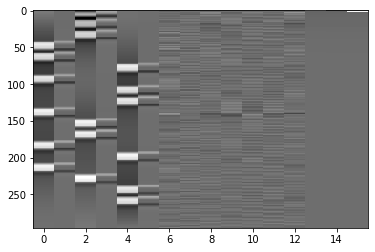

In [24]:
desmtx=numpy.loadtxt(modelgen_results.outputs.design_file,skiprows=5)
plt.imshow(desmtx,aspect='auto',interpolation='nearest',cmap='gray')

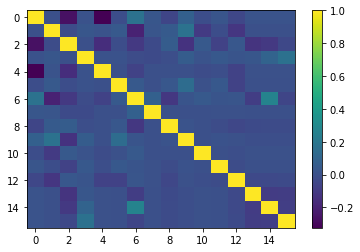

In [25]:
cc=numpy.corrcoef(desmtx.T)
plt.imshow(cc,aspect='auto',interpolation='nearest', cmap=plt.cm.viridis)
plt.colorbar()

In [26]:
mask = mem.cache(fsl.maths.ApplyMask)
mask_results = mask(in_file=skip_results.outputs.roi_file,
                    mask_file=os.path.join(datadir, "derivatives", "fmriprep", 
                                        "sub-%s"%source_epi.subject, "ses-%s"%source_epi.session, "func", 
                                        "sub-%s_ses-%s_task-image_space-MNI152NLin2009cAsym_res-2_desc-brain_mask.nii.gz"%(source_epi.subject,
                                                                                                                             source_epi.session)))

210518-09:23:36,17 nipype.workflow INFO:
	 [Node] Setting-up "6ccb6ba244d41effd94a86a26452fe9d" in "/home/vanessa.d/repositories/microbiome2brain/exp/exp21-postFmriprepAnalyses/nipype_mem/nipype-interfaces-fsl-maths-ApplyMask/6ccb6ba244d41effd94a86a26452fe9d".
210518-09:23:36,22 nipype.workflow INFO:
	 [Node] Cached "6ccb6ba244d41effd94a86a26452fe9d" - collecting precomputed outputs
210518-09:23:36,23 nipype.workflow INFO:
	 [Node] "6ccb6ba244d41effd94a86a26452fe9d" found cached.


In [27]:
modelgen_results.outputs.fcon_file
filmgls= mem.cache(fsl.FILMGLS)
filmgls

PipeFunc(nipype.interfaces.fsl.model.FILMGLS), base_dir=/home/vanessa.d/repositories/microbiome2brain/exp/exp21-postFmriprepAnalyses/nipype_mem)

In [28]:
filmgls= mem.cache(fsl.FILMGLS)
filmgls_results = filmgls(in_file=mask_results.outputs.out_file,
                          design_file = modelgen_results.outputs.design_file,
                          tcon_file = modelgen_results.outputs.con_file,
                          fcon_file = modelgen_results.outputs.fcon_file,
                          autocorr_noestimate = True)
filmgls_results.outputs

210518-09:23:41,892 nipype.workflow INFO:
	 [Node] Setting-up "8d67a35ba4c4f48936640899c717b9a8" in "/home/vanessa.d/repositories/microbiome2brain/exp/exp21-postFmriprepAnalyses/nipype_mem/nipype-interfaces-fsl-model-FILMGLS/8d67a35ba4c4f48936640899c717b9a8".
210518-09:23:41,903 nipype.workflow INFO:
	 [Node] Running "8d67a35ba4c4f48936640899c717b9a8" ("nipype.interfaces.fsl.model.FILMGLS"), a CommandLine Interface with command:
film_gls --noest --fcon=/home/vanessa.d/repositories/microbiome2brain/exp/exp21-postFmriprepAnalyses/nipype_mem/nipype-interfaces-fsl-model-FEATModel/05be0203daca41cefdd0c61153955299/run0.fts --rn=results --con=/home/vanessa.d/repositories/microbiome2brain/exp/exp21-postFmriprepAnalyses/nipype_mem/nipype-interfaces-fsl-model-FEATModel/05be0203daca41cefdd0c61153955299/run0.con --in=/home/vanessa.d/repositories/microbiome2brain/exp/exp21-postFmriprepAnalyses/nipype_mem/nipype-interfaces-fsl-maths-ApplyMask/6ccb6ba244d41effd94a86a26452fe9d/sub-E4_ses-01_task-image


copes = ['/home/vanessa.d/repositories/microbiome2brain/exp/exp21-postFmriprepAnalyses/nipype_mem/nipype-interfaces-fsl-model-FILMGLS/8d67a35ba4c4f48936640899c717b9a8/results/cope1.nii.gz', '/home/vanessa.d/repositories/microbiome2brain/exp/exp21-postFmriprepAnalyses/nipype_mem/nipype-interfaces-fsl-model-FILMGLS/8d67a35ba4c4f48936640899c717b9a8/results/cope2.nii.gz', '/home/vanessa.d/repositories/microbiome2brain/exp/exp21-postFmriprepAnalyses/nipype_mem/nipype-interfaces-fsl-model-FILMGLS/8d67a35ba4c4f48936640899c717b9a8/results/cope3.nii.gz', '/home/vanessa.d/repositories/microbiome2brain/exp/exp21-postFmriprepAnalyses/nipype_mem/nipype-interfaces-fsl-model-FILMGLS/8d67a35ba4c4f48936640899c717b9a8/results/cope4.nii.gz', '/home/vanessa.d/repositories/microbiome2brain/exp/exp21-postFmriprepAnalyses/nipype_mem/nipype-interfaces-fsl-model-FILMGLS/8d67a35ba4c4f48936640899c717b9a8/results/cope5.nii.gz', '/home/vanessa.d/repositories/microbiome2brain/exp/exp21-postFmriprepAnalyses/nipype_

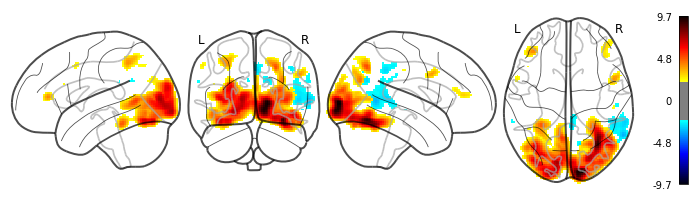

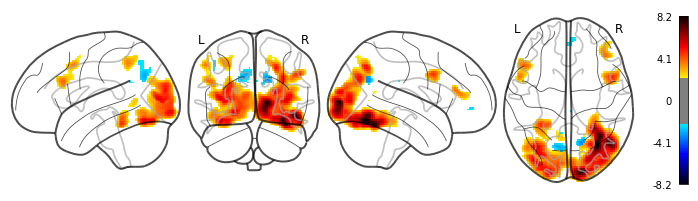

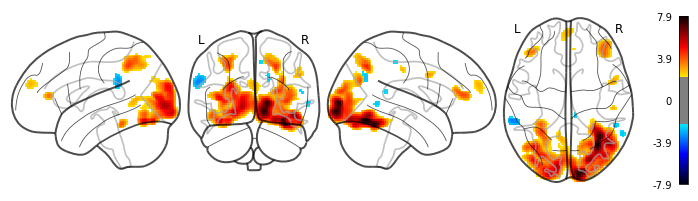

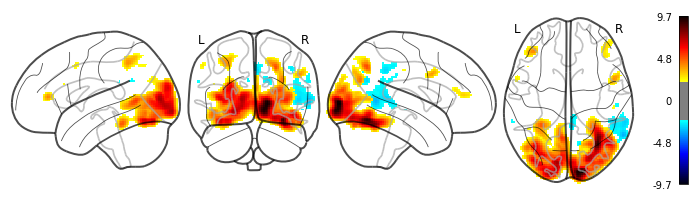

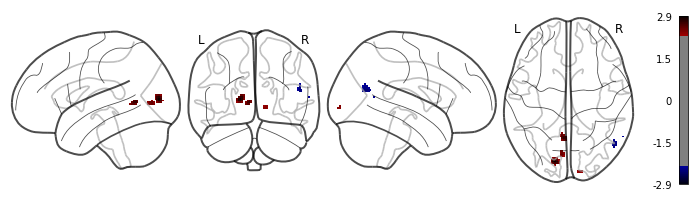

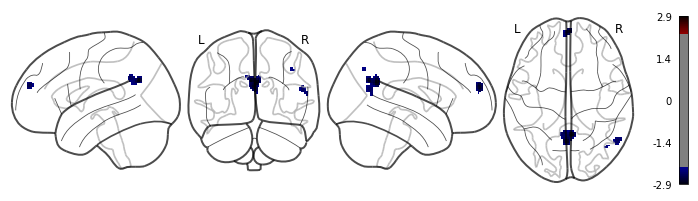

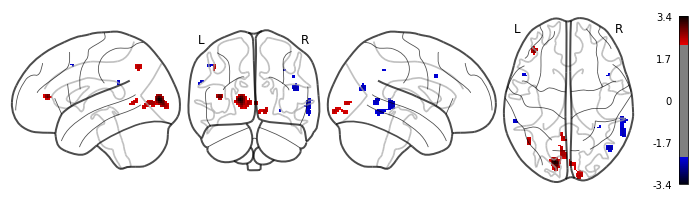

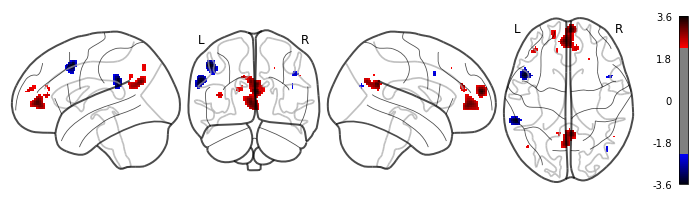

In [29]:
for t_map in filmgls_results.outputs.zstats:
    nilearn.plotting.plot_glass_brain(nilearn.image.smooth_img(t_map, 8),
                                      display_mode='lyrz', colorbar=True, plot_abs=False, threshold=2.3)

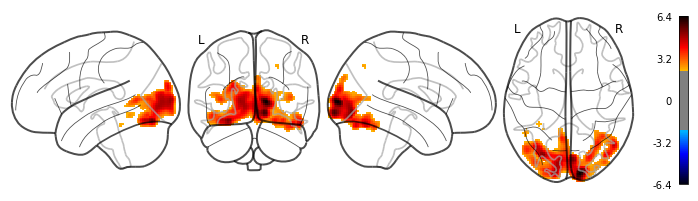

In [1211]:
for t_map in [filmgls_results.outputs.zfstats]:
    nilearn.plotting.plot_glass_brain(nilearn.image.smooth_img(t_map, 8),
                                      display_mode='lyrz', colorbar=True, plot_abs=False, threshold=2.3)

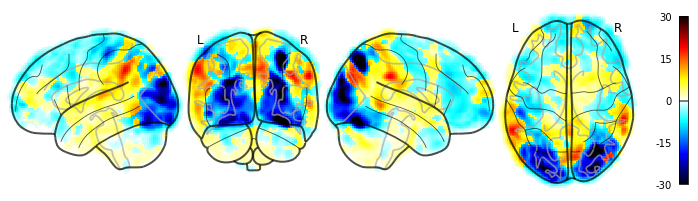

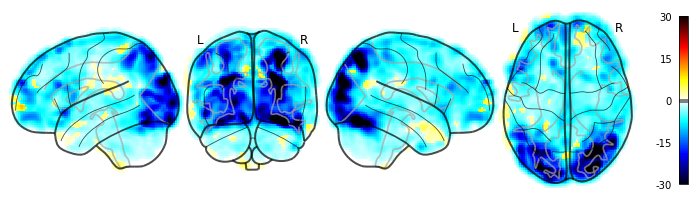

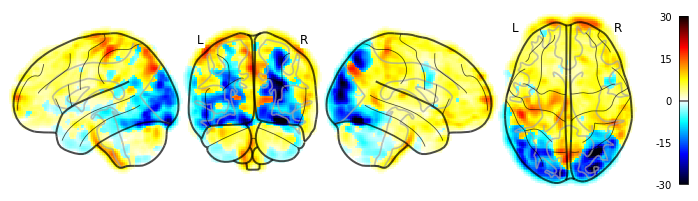

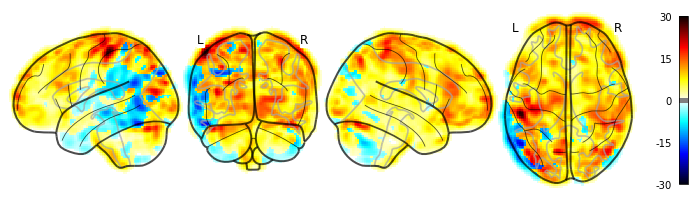

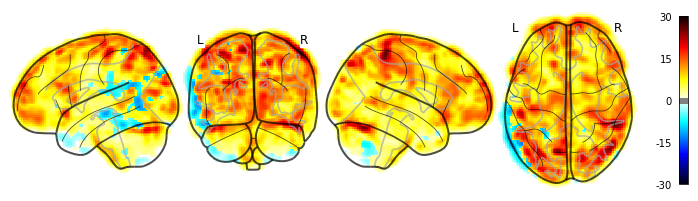

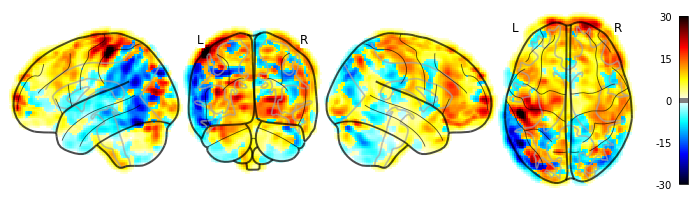

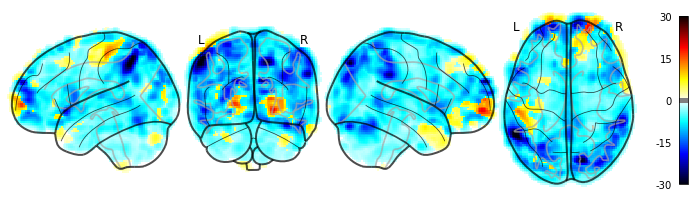

In [310]:
for t_map in filmgls_results.outputs.copes:
    nilearn.plotting.plot_glass_brain(nilearn.image.smooth_img(t_map, 8),
                                      display_mode='lyrz', colorbar=True, plot_abs=False, vmax=30)

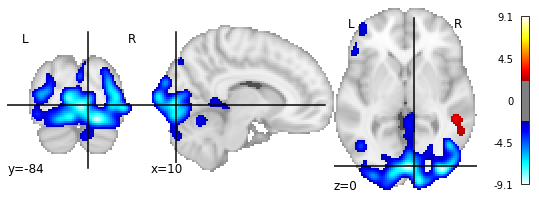

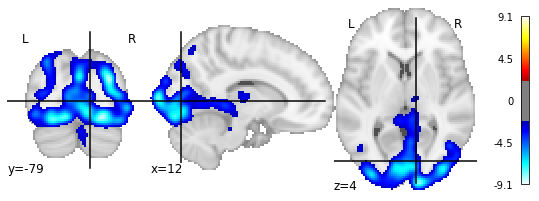

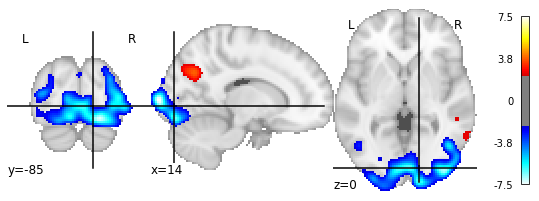

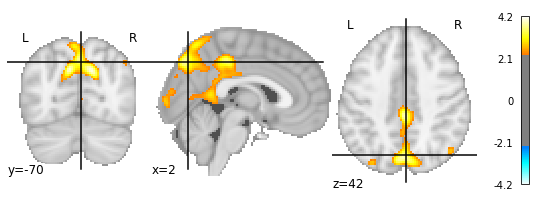

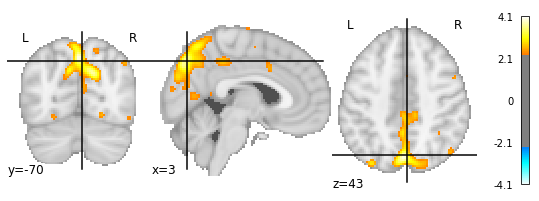

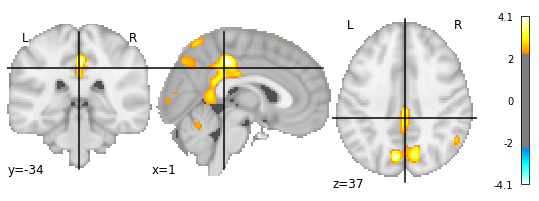

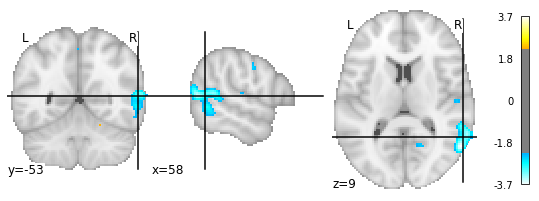

In [183]:
for t_map in filmgls_results.outputs.tstats:
    nilearn.plotting.plot_stat_map(nilearn.image.smooth_img(t_map, 8), colorbar=True, threshold=2.3)

## Repeat for all subjects

For the group level analysis we need to move results from all subjects into one common MNI space. Let's start with the EPI derived mask (we will use it later for group level mask)

In [30]:
copes = {}
varcopes = {}
for i in [0, 3, 6]:
    source_epi = layout.get(type="bold", task="image", session="01", extensions="nii.gz")[i]

    confounds = pd.read_csv(os.path.join(datadir, "derivatives", "fmriprep", 
                                            "sub-%s"%source_epi.subject, "ses-%s"%source_epi.session, "func", 
                                            "sub-%s_ses-%s_task-image_desc-confounds_timeseries.tsv"%(source_epi.subject,
                                                                                                                               source_epi.session)),
               sep="\t", na_values="n/a")
    
    events = pd.read_csv(os.path.join(datadir, "sub-%s"%source_epi.subject, "ses-%s"%source_epi.session, "func",
                                      "sub-%s_ses-%s_task-image_events.tsv"%(source_epi.subject,
                                                                                                                               source_epi.session)),
                         sep="\t")

    info = [Bunch(conditions=['Control',
                          'Healthy',
                          'Unhealthy'],
              onsets=[list(events[events.trial_type == 'Control'].onset-8),
                      list(events[events.trial_type == 'Healthy'].onset-8),
                      list(events[events.trial_type == 'Unhealthy'].onset-8),
                      list(events[events.trial_type == 'rest'].onset-8)],
              durations=[list(events[events.trial_type == 'Control'].duration),
                         list(events[events.trial_type == 'Healthy'].duration),
                         list(events[events.trial_type == 'Unhealthy'].duration),
                         list(events[events.trial_type == 'rest'].duration)],
             regressors=[list(confounds.framewise_displacement.fillna(0)),
                         list(confounds.a_comp_cor_00),
                         list(confounds.a_comp_cor_01),
                         list(confounds.a_comp_cor_02),
                         list(confounds.a_comp_cor_03),
                         list(confounds.a_comp_cor_04),
                         list(confounds.a_comp_cor_05),
                         list(confounds.non_steady_state_outlier00),
                         list(confounds.non_steady_state_outlier01),
                         list(confounds.non_steady_state_outlier02)
                        ],
             regressor_names=['framewise_displacement',
                              'a_comp_cor_00',
                              'a_comp_cor_01',
                              'a_comp_cor_02',
                              'a_comp_cor_03',
                              'a_comp_cor_04',
                              'a_comp_cor_05',
                              'non_steady_state_outlier00',
                              'non_steady_state_outlier01',
                              'non_steady_state_outlier02'])
       ]


    skip = mem.cache(fsl.ExtractROI)
    skip_results = skip(in_file=os.path.join(datadir, "derivatives", "fmriprep", 
                                            "sub-%s"%source_epi.subject, 
                                             "ses-%s"%source_epi.session,
                                             "func",
                                             "sub-%s_ses-%s_task-image_space-MNI152NLin2009cAsym_res-2_desc-preproc_bold.nii.gz"%(source_epi.subject,source_epi.session)),
                        t_min=4, t_size=-1)

    s = model.SpecifyModel()
    s.inputs.input_units = 'secs'
    s.inputs.functional_runs = skip_results.outputs.roi_file
    s.inputs.time_repetition = layout.get_metadata(source_epi.filename)["RepetitionTime"]
    s.inputs.high_pass_filter_cutoff = 128.
    s.inputs.subject_info = info
    specify_model_results = s.run()
    
    control_cond = ['Control','T', ['Control'],[1]]
    healthy_cond = ['Healthy','T', ['Healthy'],[1]]
    unhealthy_cond = ['Unhealthy','T', ['Unhealthy'],[1]]
    unhealthy_vs_others = ["Unhealthy vs. others",'T', ['Control', 'Healthy', 'Unhealthy'],[-0.5, -0.5, 1]]
    unhealthy_vs_healthy = ["Unhealthy vs. healthy",'T', ['Healthy', 'Unhealthy'],[-1, 1]]
    unhealthy_vs_control = ["Unhealthy vs. control",'T', ['Control', 'Unhealthy'],[-1, 1]]
    healthy_vs_control = ["Healthy vs. control",'T', ['Control', 'Healthy'],[-1, 1]]
    food_vs_control = ["Food vs. control",'T', ['Control', 'Healthy', 'Unhealthy'],[-1, 0.5, 0.5]]


    all_images = ["All images", 'F', [control_cond, healthy_cond, unhealthy_cond]]
    contrasts=[control_cond, healthy_cond, unhealthy_cond, 
               unhealthy_vs_others, unhealthy_vs_healthy, unhealthy_vs_control, healthy_vs_control, food_vs_control,
               all_images]

    level1design = mem.cache(fsl.model.Level1Design)
    level1design_results = level1design(interscan_interval = layout.get_metadata(source_epi.filename)["RepetitionTime"],
                                        bases = {'dgamma':{'derivs': True}},
                                        session_info = specify_model_results.outputs.session_info,
                                        model_serial_correlations=True,
                                        contrasts=contrasts)


    modelgen = mem.cache(fsl.model.FEATModel)
    modelgen_results = modelgen(fsf_file=level1design_results.outputs.fsf_files,
                            ev_files=level1design_results.outputs.ev_files)

    mask = mem.cache(fsl.maths.ApplyMask)
    mask_results = mask(in_file=skip_results.outputs.roi_file,
                    mask_file=os.path.join(datadir, "derivatives", "fmriprep", 
                                        "sub-%s"%source_epi.subject, "ses-%s"%source_epi.session, "func", 
                                        "sub-%s_ses-%s_task-image_space-MNI152NLin2009cAsym_res-2_desc-brain_mask.nii.gz"%(source_epi.subject,
                                                                                                                          source_epi.session)))
    
    filmgls= mem.cache(fsl.FILMGLS)
    filmgls_results = filmgls(in_file=mask_results.outputs.out_file,
                          design_file = modelgen_results.outputs.design_file,
                          tcon_file = modelgen_results.outputs.con_file,
                          fcon_file = modelgen_results.outputs.fcon_file,
                          autocorr_noestimate = True)
                                                                                                                          
    copes[source_epi.subject+"-"+source_epi.session] = list(filmgls_results.outputs.copes)
    varcopes[source_epi.subject+"-"+source_epi.session] = list(filmgls_results.outputs.varcopes)
    
    
    for t_map in range(len(filmgls_results.outputs.zstats)):
        nilearn.plotting.plot_glass_brain(nilearn.image.smooth_img(filmgls_results.outputs.zstats[t_map], 8),
                                          display_mode='lyrz', colorbar=True,
                                          plot_abs=False, threshold=2.3,
                                          output_file=os.path.join(datadir, "derivatives", "fsl_filmgls",
                                                                   ("sub-%s_ses-%s_task-image"%(source_epi.subject,source_epi.session)+"_zstat"+str(t_map+1)+".pdf")))
    for t_map in range(len(filmgls_results.outputs.tstats)):
        nilearn.plotting.plot_stat_map(nilearn.image.smooth_img(filmgls_results.outputs.tstats[t_map], 8), 
                                       colorbar=True, threshold=2.3,
                                       output_file=os.path.join(datadir, "derivatives", "fsl_filmgls",
                                                                   ("sub-%s_ses-%s_task-image"%(source_epi.subject,source_epi.session)+"_tstat"+str(t_map+1)+".pdf")))

210518-09:43:36,809 nipype.workflow INFO:
	 [Node] Setting-up "edc15764e235cf2e899e6109275ec29d" in "/home/vanessa.d/repositories/microbiome2brain/exp/exp21-postFmriprepAnalyses/nipype_mem/nipype-interfaces-fsl-utils-ExtractROI/edc15764e235cf2e899e6109275ec29d".
210518-09:43:36,814 nipype.workflow INFO:
	 [Node] Cached "edc15764e235cf2e899e6109275ec29d" - collecting precomputed outputs
210518-09:43:36,815 nipype.workflow INFO:
	 [Node] "edc15764e235cf2e899e6109275ec29d" found cached.
210518-09:43:41,310 nipype.workflow INFO:
	 [Node] Setting-up "ae445fe2d97501bd1c332f339a8e0911" in "/home/vanessa.d/repositories/microbiome2brain/exp/exp21-postFmriprepAnalyses/nipype_mem/nipype-interfaces-fsl-model-Level1Design/ae445fe2d97501bd1c332f339a8e0911".
210518-09:43:41,330 nipype.workflow INFO:
	 [Node] Cached "ae445fe2d97501bd1c332f339a8e0911" - collecting precomputed outputs
210518-09:43:41,331 nipype.workflow INFO:
	 [Node] "ae445fe2d97501bd1c332f339a8e0911" found cached.
210518-09:43:41,480 

In [31]:
varcopes

{'E1-01': ['/home/vanessa.d/repositories/microbiome2brain/exp/exp21-postFmriprepAnalyses/nipype_mem/nipype-interfaces-fsl-model-FILMGLS/08ba63dc6d46971f06ff8c2c083e0e54/results/varcope1.nii.gz',
  '/home/vanessa.d/repositories/microbiome2brain/exp/exp21-postFmriprepAnalyses/nipype_mem/nipype-interfaces-fsl-model-FILMGLS/08ba63dc6d46971f06ff8c2c083e0e54/results/varcope2.nii.gz',
  '/home/vanessa.d/repositories/microbiome2brain/exp/exp21-postFmriprepAnalyses/nipype_mem/nipype-interfaces-fsl-model-FILMGLS/08ba63dc6d46971f06ff8c2c083e0e54/results/varcope3.nii.gz',
  '/home/vanessa.d/repositories/microbiome2brain/exp/exp21-postFmriprepAnalyses/nipype_mem/nipype-interfaces-fsl-model-FILMGLS/08ba63dc6d46971f06ff8c2c083e0e54/results/varcope4.nii.gz',
  '/home/vanessa.d/repositories/microbiome2brain/exp/exp21-postFmriprepAnalyses/nipype_mem/nipype-interfaces-fsl-model-FILMGLS/08ba63dc6d46971f06ff8c2c083e0e54/results/varcope5.nii.gz',
  '/home/vanessa.d/repositories/microbiome2brain/exp/exp21-po

In [32]:
copes2 = {}
varcopes2 = {}
for i in [1, 4]:
    source_epi = layout.get(type="bold", task="image", session="01", extensions="nii.gz")[i]

    confounds = pd.read_csv(os.path.join(datadir, "derivatives", "fmriprep", 
                                            "sub-%s"%source_epi.subject, "ses-%s"%source_epi.session, "func", 
                                            "sub-%s_ses-%s_task-image_desc-confounds_timeseries.tsv"%(source_epi.subject,
                                                                                                                               source_epi.session)),
               sep="\t", na_values="n/a")
    
    events = pd.read_csv(os.path.join(datadir, "sub-%s"%source_epi.subject, "ses-%s"%source_epi.session, "func",
                                      "sub-%s_ses-%s_task-image_events.tsv"%(source_epi.subject,
                                                                                                                               source_epi.session)),
                         sep="\t")

    info = [Bunch(conditions=['Control',
                          'Healthy',
                          'Unhealthy'],
              onsets=[list(events[events.trial_type == 'Control'].onset-8),
                      list(events[events.trial_type == 'Healthy'].onset-8),
                      list(events[events.trial_type == 'Unhealthy'].onset-8),
                      list(events[events.trial_type == 'rest'].onset-8)],
              durations=[list(events[events.trial_type == 'Control'].duration),
                         list(events[events.trial_type == 'Healthy'].duration),
                         list(events[events.trial_type == 'Unhealthy'].duration),
                         list(events[events.trial_type == 'rest'].duration)],
             regressors=[list(confounds.framewise_displacement.fillna(0)),
                         list(confounds.a_comp_cor_00),
                         list(confounds.a_comp_cor_01),
                         list(confounds.a_comp_cor_02),
                         list(confounds.a_comp_cor_03),
                         list(confounds.a_comp_cor_04),
                         list(confounds.a_comp_cor_05),
                         list(confounds.non_steady_state_outlier00),
                         list(confounds.non_steady_state_outlier01),
                         list(confounds.non_steady_state_outlier02)
                        ],
             regressor_names=['framewise_displacement',
                              'a_comp_cor_00',
                              'a_comp_cor_01',
                              'a_comp_cor_02',
                              'a_comp_cor_03',
                              'a_comp_cor_04',
                              'a_comp_cor_05',
                              'non_steady_state_outlier00',
                              'non_steady_state_outlier01',
                              'non_steady_state_outlier02'])
       ]

    skip = mem.cache(fsl.ExtractROI)
    skip_results = skip(in_file=os.path.join(datadir, "derivatives", "fmriprep", 
                                            "sub-%s"%source_epi.subject, 
                                             "ses-%s"%source_epi.session,
                                             "func",
                                             "sub-%s_ses-%s_task-image_space-MNI152NLin2009cAsym_res-2_desc-preproc_bold.nii.gz"%(source_epi.subject,source_epi.session)),
                        t_min=4, t_size=-1)

    s = model.SpecifyModel()
    s.inputs.input_units = 'secs'
    s.inputs.functional_runs = skip_results.outputs.roi_file
    s.inputs.time_repetition = layout.get_metadata(source_epi.filename)["RepetitionTime"]
    s.inputs.high_pass_filter_cutoff = 128.
    s.inputs.subject_info = info
    specify_model_results = s.run()
    
    control_cond = ['Control','T', ['Control'],[1]]
    healthy_cond = ['Healthy','T', ['Healthy'],[1]]
    unhealthy_cond = ['Unhealthy','T', ['Unhealthy'],[1]]
    unhealthy_vs_others = ["Unhealthy vs. others",'T', ['Control', 'Healthy', 'Unhealthy'],[-0.5, -0.5, 1]]
    unhealthy_vs_healthy = ["Unhealthy vs. healthy",'T', ['Healthy', 'Unhealthy'],[-1, 1]]
    unhealthy_vs_control = ["Unhealthy vs. control",'T', ['Control', 'Unhealthy'],[-1, 1]]
    healthy_vs_control = ["Healthy vs. control",'T', ['Control', 'Healthy'],[-1, 1]]
    food_vs_control = ["Food vs. control",'T', ['Control', 'Healthy', 'Unhealthy'],[-1, 0.5, 0.5]]

    all_images = ["All images", 'F', [control_cond, healthy_cond, unhealthy_cond]]
    contrasts=[control_cond, healthy_cond, unhealthy_cond, 
               unhealthy_vs_others, unhealthy_vs_healthy, unhealthy_vs_control, healthy_vs_control, food_vs_control,
               all_images]

    level1design = mem.cache(fsl.model.Level1Design)
    level1design_results = level1design(interscan_interval = layout.get_metadata(source_epi.filename)["RepetitionTime"],
                                        bases = {'dgamma':{'derivs': True}},
                                        session_info = specify_model_results.outputs.session_info,
                                        model_serial_correlations=True,
                                        contrasts=contrasts)


    modelgen = mem.cache(fsl.model.FEATModel)
    modelgen_results = modelgen(fsf_file=level1design_results.outputs.fsf_files,
                            ev_files=level1design_results.outputs.ev_files)

    mask = mem.cache(fsl.maths.ApplyMask)
    mask_results = mask(in_file=skip_results.outputs.roi_file,
                    mask_file=os.path.join(datadir, "derivatives", "fmriprep", 
                                        "sub-%s"%source_epi.subject, "ses-%s"%source_epi.session, "func", 
                                        "sub-%s_ses-%s_task-image_space-MNI152NLin2009cAsym_res-2_desc-brain_mask.nii.gz"%(source_epi.subject,
                                                                                                                          source_epi.session)))
    
    filmgls= mem.cache(fsl.FILMGLS)
    filmgls_results = filmgls(in_file=mask_results.outputs.out_file,
                          design_file = modelgen_results.outputs.design_file,
                          tcon_file = modelgen_results.outputs.con_file,
                          fcon_file = modelgen_results.outputs.fcon_file,
                          autocorr_noestimate = True)
                                                                                                                          
    copes2[source_epi.subject+"-"+source_epi.session] = list(filmgls_results.outputs.copes)
    varcopes2[source_epi.subject+"-"+source_epi.session] = list(filmgls_results.outputs.varcopes)
    
    for t_map in range(len(filmgls_results.outputs.zstats)):
        nilearn.plotting.plot_glass_brain(nilearn.image.smooth_img(filmgls_results.outputs.zstats[t_map], 8),
                                          display_mode='lyrz', colorbar=True,
                                          plot_abs=False, threshold=2.3,
                                          output_file=os.path.join(datadir, "derivatives", "fsl_filmgls",
                                                                   ("sub-%s_ses-%s_task-image"%(source_epi.subject,source_epi.session)+"_zstat"+str(t_map+1)+".pdf")))
        
    for t_map in range(len(filmgls_results.outputs.tstats)):
        nilearn.plotting.plot_stat_map(nilearn.image.smooth_img(filmgls_results.outputs.tstats[t_map], 8), 
                                       colorbar=True, threshold=2.3,
                                       output_file=os.path.join(datadir, "derivatives", "fsl_filmgls",
                                                                   ("sub-%s_ses-%s_task-image"%(source_epi.subject,source_epi.session)+"_tstat"+str(t_map+1)+".pdf")))

210518-09:49:23,930 nipype.workflow INFO:
	 [Node] Setting-up "cd4c324029cf4fb83f978f5739895b43" in "/home/vanessa.d/repositories/microbiome2brain/exp/exp21-postFmriprepAnalyses/nipype_mem/nipype-interfaces-fsl-utils-ExtractROI/cd4c324029cf4fb83f978f5739895b43".
210518-09:49:23,935 nipype.workflow INFO:
	 [Node] Cached "cd4c324029cf4fb83f978f5739895b43" - collecting precomputed outputs
210518-09:49:23,937 nipype.workflow INFO:
	 [Node] "cd4c324029cf4fb83f978f5739895b43" found cached.
210518-09:49:28,495 nipype.workflow INFO:
	 [Node] Setting-up "987ba960e487ae98b26d29ced2b6cc88" in "/home/vanessa.d/repositories/microbiome2brain/exp/exp21-postFmriprepAnalyses/nipype_mem/nipype-interfaces-fsl-model-Level1Design/987ba960e487ae98b26d29ced2b6cc88".
210518-09:49:28,567 nipype.workflow INFO:
	 [Node] Running "987ba960e487ae98b26d29ced2b6cc88" ("nipype.interfaces.fsl.model.Level1Design")
210518-09:49:28,724 nipype.workflow INFO:
	 [Node] Finished "987ba960e487ae98b26d29ced2b6cc88".
210518-09:4

210518-09:57:15,555 nipype.interface INFO:
	 stdout 2021-05-18T09:57:15.553384:paradigm.getDesignMatrix().Ncols()=16
210518-09:57:15,556 nipype.interface INFO:
	 stdout 2021-05-18T09:57:15.553384:sizeTS=276
210518-09:57:15,557 nipype.interface INFO:
	 stdout 2021-05-18T09:57:15.553384:numTS=252301
210518-09:57:15,830 nipype.interface INFO:
	 stdout 2021-05-18T09:57:15.830400:Completed
210518-09:57:15,831 nipype.interface INFO:
	 stdout 2021-05-18T09:57:15.830400:Prewhitening and Computing PEs...
210518-09:57:15,832 nipype.interface INFO:
	 stdout 2021-05-18T09:57:15.830400:Percentage done:
210518-10:01:58,414 nipype.interface INFO:
	 stdout 2021-05-18T10:01:58.414107:1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,Completed
210518-10:01:58,417 nipype

/home/vanessa.d/anaconda3/envs/nipype/lib/python3.6/site-packages/nilearn/plotting/displays.py:880: UserWarning: empty mask
  get_mask_bounds(new_img_like(img, not_mask, affine))
/home/vanessa.d/anaconda3/envs/nipype/lib/python3.6/site-packages/nilearn/plotting/find_cuts.py:141: UserWarning: Could not determine cut coords: All voxels were masked by the thresholding. Returning the center of mass instead.
  "Could not determine cut coords: "
/home/vanessa.d/anaconda3/envs/nipype/lib/python3.6/site-packages/nilearn/plotting/displays.py:880: UserWarning: empty mask
  get_mask_bounds(new_img_like(img, not_mask, affine))


In [33]:
copes3 = {}
varcopes3 = {}
for i in [2, 5]:
    source_epi = layout.get(type="bold", task="image", session="01", extensions="nii.gz")[i]

    confounds = pd.read_csv(os.path.join(datadir, "derivatives", "fmriprep", 
                                            "sub-%s"%source_epi.subject, "ses-%s"%source_epi.session, "func", 
                                            "sub-%s_ses-%s_task-image_desc-confounds_timeseries.tsv"%(source_epi.subject,
                                                                                                                               source_epi.session)),
               sep="\t", na_values="n/a")
    
    events = pd.read_csv(os.path.join(datadir, "sub-%s"%source_epi.subject, "ses-%s"%source_epi.session, "func",
                                      "sub-%s_ses-%s_task-image_events.tsv"%(source_epi.subject,
                                                                                                                               source_epi.session)),
                         sep="\t")

    info = [Bunch(conditions=['Control',
                          'Healthy',
                          'Unhealthy'],
              onsets=[list(events[events.trial_type == 'Control'].onset-8),
                      list(events[events.trial_type == 'Healthy'].onset-8),
                      list(events[events.trial_type == 'Unhealthy'].onset-8),
                      list(events[events.trial_type == 'rest'].onset-8)],
              durations=[list(events[events.trial_type == 'Control'].duration),
                         list(events[events.trial_type == 'Healthy'].duration),
                         list(events[events.trial_type == 'Unhealthy'].duration),
                         list(events[events.trial_type == 'rest'].duration)],
             regressors=[list(confounds.framewise_displacement.fillna(0)),
                         list(confounds.a_comp_cor_00),
                         list(confounds.a_comp_cor_01),
                         list(confounds.a_comp_cor_02),
                         list(confounds.a_comp_cor_03),
                         list(confounds.a_comp_cor_04),
                         list(confounds.a_comp_cor_05),
                         list(confounds.non_steady_state_outlier00),
                         list(confounds.non_steady_state_outlier01),
                         list(confounds.non_steady_state_outlier02)
                        ],
             regressor_names=['framewise_displacement',
                              'a_comp_cor_00',
                              'a_comp_cor_01',
                              'a_comp_cor_02',
                              'a_comp_cor_03',
                              'a_comp_cor_04',
                              'a_comp_cor_05',
                              'non_steady_state_outlier00',
                              'non_steady_state_outlier01',
                              'non_steady_state_outlier02'])
       ]


    skip = mem.cache(fsl.ExtractROI)
    skip_results = skip(in_file=os.path.join(datadir, "derivatives", "fmriprep", 
                                            "sub-%s"%source_epi.subject, 
                                             "ses-%s"%source_epi.session,
                                             "func",
                                             "sub-%s_ses-%s_task-image_space-MNI152NLin2009cAsym_res-2_desc-preproc_bold.nii.gz"%(source_epi.subject,source_epi.session)),
                        t_min=4, t_size=-1)

    s = model.SpecifyModel()
    s.inputs.input_units = 'secs'
    s.inputs.functional_runs = skip_results.outputs.roi_file
    s.inputs.time_repetition = layout.get_metadata(source_epi.filename)["RepetitionTime"]
    s.inputs.high_pass_filter_cutoff = 128.
    s.inputs.subject_info = info
    specify_model_results = s.run()
    
    control_cond = ['Control','T', ['Control'],[1]]
    healthy_cond = ['Healthy','T', ['Healthy'],[1]]
    unhealthy_cond = ['Unhealthy','T', ['Unhealthy'],[1]]
    unhealthy_vs_others = ["Unhealthy vs. others",'T', ['Control', 'Healthy', 'Unhealthy'],[-0.5, -0.5, 1]]
    unhealthy_vs_healthy = ["Unhealthy vs. healthy",'T', ['Healthy', 'Unhealthy'],[-1, 1]]
    unhealthy_vs_control = ["Unhealthy vs. control",'T', ['Control', 'Unhealthy'],[-1, 1]]
    food_vs_control = ["Food vs. control",'T', ['Control', 'Healthy', 'Unhealthy'],[-1, 0.5, 0.5]]
    
    all_images = ["All images", 'F', [control_cond, healthy_cond, unhealthy_cond]]
    contrasts=[control_cond, healthy_cond, unhealthy_cond, 
               unhealthy_vs_others, unhealthy_vs_healthy, unhealthy_vs_control, healthy_vs_control, food_vs_control,
               all_images]

    level1design = mem.cache(fsl.model.Level1Design)
    level1design_results = level1design(interscan_interval = layout.get_metadata(source_epi.filename)["RepetitionTime"],
                                        bases = {'dgamma':{'derivs': True}},
                                        session_info = specify_model_results.outputs.session_info,
                                        model_serial_correlations=True,
                                        contrasts=contrasts)


    modelgen = mem.cache(fsl.model.FEATModel)
    modelgen_results = modelgen(fsf_file=level1design_results.outputs.fsf_files,
                            ev_files=level1design_results.outputs.ev_files)

    mask = mem.cache(fsl.maths.ApplyMask)
    mask_results = mask(in_file=skip_results.outputs.roi_file,
                    mask_file=os.path.join(datadir, "derivatives", "fmriprep", 
                                        "sub-%s"%source_epi.subject, "ses-%s"%source_epi.session, "func", 
                                        "sub-%s_ses-%s_task-image_space-MNI152NLin2009cAsym_res-2_desc-brain_mask.nii.gz"%(source_epi.subject,
                                                                                                                          source_epi.session)))
    
    filmgls= mem.cache(fsl.FILMGLS)
    filmgls_results = filmgls(in_file=mask_results.outputs.out_file,
                          design_file = modelgen_results.outputs.design_file,
                          tcon_file = modelgen_results.outputs.con_file,
                          fcon_file = modelgen_results.outputs.fcon_file,
                          autocorr_noestimate = True)
                                                                                                                          
    copes3[source_epi.subject+"-"+source_epi.session] = list(filmgls_results.outputs.copes)
    varcopes3[source_epi.subject+"-"+source_epi.session] = list(filmgls_results.outputs.varcopes)
    
    for t_map in range(len(filmgls_results.outputs.zstats)):
        nilearn.plotting.plot_glass_brain(nilearn.image.smooth_img(filmgls_results.outputs.zstats[t_map], 8),
                                          display_mode='lyrz', colorbar=True,
                                          plot_abs=False, threshold=2.3,
                                          output_file=os.path.join(datadir, "derivatives", "fsl_filmgls",
                                                                   ("sub-%s_ses-%s_task-image"%(source_epi.subject,source_epi.session)+"_zstat"+str(t_map+1)+".pdf")))
        
    for t_map in range(len(filmgls_results.outputs.tstats)):
        nilearn.plotting.plot_stat_map(nilearn.image.smooth_img(filmgls_results.outputs.tstats[t_map], 8), 
                                       colorbar=True, threshold=2.3,
                                       output_file=os.path.join(datadir, "derivatives", "fsl_filmgls",
                                                                   ("sub-%s_ses-%s_task-image"%(source_epi.subject,source_epi.session)+"_tstat"+str(t_map+1)+".pdf")))

AttributeError: 'DataFrame' object has no attribute 'non_steady_state_outlier02'

In [ ]:
copes4 = {}
varcopes4 = {}
for i in [0, 3, 4]:
    source_epi = layout.get(type="bold", task="image", session="02", extensions="nii.gz")[i]

    confounds = pd.read_csv(os.path.join(datadir, "derivatives", "fmriprep", 
                                            "sub-%s"%source_epi.subject, "ses-%s"%source_epi.session, "func", 
                                            "sub-%s_ses-%s_task-image_desc-confounds_timeseries.tsv"%(source_epi.subject,
                                                                                                                               source_epi.session)),
               sep="\t", na_values="n/a")
    
    events = pd.read_csv(os.path.join(datadir, "sub-%s"%source_epi.subject, "ses-%s"%source_epi.session, "func",
                                      "sub-%s_ses-%s_task-image_events.tsv"%(source_epi.subject,
                                                                                                                               source_epi.session)),
                         sep="\t")

    info = [Bunch(conditions=['Control',
                          'Healthy',
                          'Unhealthy'],
              onsets=[list(events[events.trial_type == 'Control'].onset-8),
                      list(events[events.trial_type == 'Healthy'].onset-8),
                      list(events[events.trial_type == 'Unhealthy'].onset-8),
                      list(events[events.trial_type == 'rest'].onset-8)],
              durations=[list(events[events.trial_type == 'Control'].duration),
                         list(events[events.trial_type == 'Healthy'].duration),
                         list(events[events.trial_type == 'Unhealthy'].duration),
                         list(events[events.trial_type == 'rest'].duration)],
             regressors=[list(confounds.framewise_displacement.fillna(0)),
                         list(confounds.a_comp_cor_00),
                         list(confounds.a_comp_cor_01),
                         list(confounds.a_comp_cor_02),
                         list(confounds.a_comp_cor_03),
                         list(confounds.a_comp_cor_04),
                         list(confounds.a_comp_cor_05),
                         list(confounds.non_steady_state_outlier00),
                         list(confounds.non_steady_state_outlier01),
                         list(confounds.non_steady_state_outlier02)
                        ],
             regressor_names=['framewise_displacement',
                              'a_comp_cor_00',
                              'a_comp_cor_01',
                              'a_comp_cor_02',
                              'a_comp_cor_03',
                              'a_comp_cor_04',
                              'a_comp_cor_05',
                              'non_steady_state_outlier00',
                              'non_steady_state_outlier01',
                              'non_steady_state_outlier02'])
       ]


    skip = mem.cache(fsl.ExtractROI)
    skip_results = skip(in_file=os.path.join(datadir, "derivatives", "fmriprep", 
                                            "sub-%s"%source_epi.subject, 
                                             "ses-%s"%source_epi.session,
                                             "func",
                                             "sub-%s_ses-%s_task-image_space-MNI152NLin2009cAsym_res-2_desc-preproc_bold.nii.gz"%(source_epi.subject,source_epi.session)),
                        t_min=4, t_size=-1)

    s = model.SpecifyModel()
    s.inputs.input_units = 'secs'
    s.inputs.functional_runs = skip_results.outputs.roi_file
    s.inputs.time_repetition = layout.get_metadata(source_epi.filename)["RepetitionTime"]
    s.inputs.high_pass_filter_cutoff = 128.
    s.inputs.subject_info = info
    specify_model_results = s.run()
    
    control_cond = ['Control','T', ['Control'],[1]]
    healthy_cond = ['Healthy','T', ['Healthy'],[1]]
    unhealthy_cond = ['Unhealthy','T', ['Unhealthy'],[1]]
    unhealthy_vs_others = ["Unhealthy vs. others",'T', ['Control', 'Healthy', 'Unhealthy'],[-0.5, -0.5, 1]]
    unhealthy_vs_healthy = ["Unhealthy vs. healthy",'T', ['Healthy', 'Unhealthy'],[-1, 1]]
    unhealthy_vs_control = ["Unhealthy vs. control",'T', ['Control', 'Unhealthy'],[-1, 1]]
    healthy_vs_control = ["Healthy vs. control",'T', ['Control', 'Healthy'],[-1, 1]]
    food_vs_control = ["Food vs. control",'T', ['Control', 'Healthy', 'Unhealthy'],[-1, 0.5, 0.5]]


    all_images = ["All images", 'F', [control_cond, healthy_cond, unhealthy_cond]]
    contrasts=[control_cond, healthy_cond, unhealthy_cond, 
               unhealthy_vs_others, unhealthy_vs_healthy, unhealthy_vs_control, healthy_vs_control, food_vs_control,
               all_images]

    level1design = mem.cache(fsl.model.Level1Design)
    level1design_results = level1design(interscan_interval = layout.get_metadata(source_epi.filename)["RepetitionTime"],
                                        bases = {'dgamma':{'derivs': True}},
                                        session_info = specify_model_results.outputs.session_info,
                                        model_serial_correlations=True,
                                        contrasts=contrasts)


    modelgen = mem.cache(fsl.model.FEATModel)
    modelgen_results = modelgen(fsf_file=level1design_results.outputs.fsf_files,
                            ev_files=level1design_results.outputs.ev_files)

    mask = mem.cache(fsl.maths.ApplyMask)
    mask_results = mask(in_file=skip_results.outputs.roi_file,
                    mask_file=os.path.join(datadir, "derivatives", "fmriprep", 
                                        "sub-%s"%source_epi.subject, "ses-%s"%source_epi.session, "func", 
                                        "sub-%s_ses-%s_task-image_space-MNI152NLin2009cAsym_res-2_desc-brain_mask.nii.gz"%(source_epi.subject,
                                                                                                                          source_epi.session)))
    
    filmgls= mem.cache(fsl.FILMGLS)
    filmgls_results = filmgls(in_file=mask_results.outputs.out_file,
                          design_file = modelgen_results.outputs.design_file,
                          tcon_file = modelgen_results.outputs.con_file,
                          fcon_file = modelgen_results.outputs.fcon_file,
                          autocorr_noestimate = True)
                                                                                                                          
    copes4[source_epi.subject+"-"+source_epi.session] = list(filmgls_results.outputs.copes)
    varcopes4[source_epi.subject+"-"+source_epi.session] = list(filmgls_results.outputs.varcopes)
    
    for t_map in range(len(filmgls_results.outputs.zstats)):
        nilearn.plotting.plot_glass_brain(nilearn.image.smooth_img(filmgls_results.outputs.zstats[t_map], 8),
                                          display_mode='lyrz', colorbar=True,
                                          plot_abs=False, threshold=2.3,
                                          output_file=os.path.join(datadir, "derivatives", "fsl_filmgls",
                                                                   ("sub-%s_ses-%s_task-image"%(source_epi.subject,source_epi.session)+"_zstat"+str(t_map+1)+".pdf")))
        
    for t_map in range(len(filmgls_results.outputs.tstats)):
        nilearn.plotting.plot_stat_map(nilearn.image.smooth_img(filmgls_results.outputs.tstats[t_map], 8), 
                                       colorbar=True, threshold=2.3,
                                       output_file=os.path.join(datadir, "derivatives", "fsl_filmgls",
                                                                   ("sub-%s_ses-%s_task-image"%(source_epi.subject,source_epi.session)+"_tstat"+str(t_map+1)+".pdf")))

In [ ]:
copes5 = {}
varcopes5 = {}
for i in [1, 2, 5]:
    source_epi = layout.get(type="bold", task="image", session="02", extensions="nii.gz")[i]

    confounds = pd.read_csv(os.path.join(datadir, "derivatives", "fmriprep", 
                                            "sub-%s"%source_epi.subject, "ses-%s"%source_epi.session, "func", 
                                            "sub-%s_ses-%s_task-image_desc-confounds_timeseries.tsv"%(source_epi.subject,
                                                                                                                               source_epi.session)),
               sep="\t", na_values="n/a")
    
    events = pd.read_csv(os.path.join(datadir, "sub-%s"%source_epi.subject, "ses-%s"%source_epi.session, "func",
                                      "sub-%s_ses-%s_task-image_events.tsv"%(source_epi.subject,
                                                                                                                               source_epi.session)),
                         sep="\t")

    info = [Bunch(conditions=['Control',
                          'Healthy',
                          'Unhealthy'],
              onsets=[list(events[events.trial_type == 'Control'].onset-8),
                      list(events[events.trial_type == 'Healthy'].onset-8),
                      list(events[events.trial_type == 'Unhealthy'].onset-8),
                      list(events[events.trial_type == 'rest'].onset-8)],
              durations=[list(events[events.trial_type == 'Control'].duration),
                         list(events[events.trial_type == 'Healthy'].duration),
                         list(events[events.trial_type == 'Unhealthy'].duration),
                         list(events[events.trial_type == 'rest'].duration)],
             regressors=[list(confounds.framewise_displacement.fillna(0)),
                         list(confounds.a_comp_cor_00),
                         list(confounds.a_comp_cor_01),
                         list(confounds.a_comp_cor_02),
                         list(confounds.a_comp_cor_03),
                         list(confounds.a_comp_cor_04),
                         list(confounds.a_comp_cor_05),
                         list(confounds.non_steady_state_outlier00),
                         list(confounds.non_steady_state_outlier01),
                         list(confounds.non_steady_state_outlier02)
                        ],
             regressor_names=['framewise_displacement',
                              'a_comp_cor_00',
                              'a_comp_cor_01',
                              'a_comp_cor_02',
                              'a_comp_cor_03',
                              'a_comp_cor_04',
                              'a_comp_cor_05',
                              'non_steady_state_outlier00',
                              'non_steady_state_outlier01',
                              'non_steady_state_outlier02'])
       ]


    skip = mem.cache(fsl.ExtractROI)
    skip_results = skip(in_file=os.path.join(datadir, "derivatives", "fmriprep", 
                                            "sub-%s"%source_epi.subject, 
                                             "ses-%s"%source_epi.session,
                                             "func",
                                             "sub-%s_ses-%s_task-image_space-MNI152NLin2009cAsym_res-2_desc-preproc_bold.nii.gz"%(source_epi.subject,source_epi.session)),
                        t_min=4, t_size=-1)

    s = model.SpecifyModel()
    s.inputs.input_units = 'secs'
    s.inputs.functional_runs = skip_results.outputs.roi_file
    s.inputs.time_repetition = layout.get_metadata(source_epi.filename)["RepetitionTime"]
    s.inputs.high_pass_filter_cutoff = 128.
    s.inputs.subject_info = info
    specify_model_results = s.run()
    
    control_cond = ['Control','T', ['Control'],[1]]
    healthy_cond = ['Healthy','T', ['Healthy'],[1]]
    unhealthy_cond = ['Unhealthy','T', ['Unhealthy'],[1]]
    unhealthy_vs_others = ["Unhealthy vs. others",'T', ['Control', 'Healthy', 'Unhealthy'],[-0.5, -0.5, 1]]
    unhealthy_vs_healthy = ["Unhealthy vs. healthy",'T', ['Healthy', 'Unhealthy'],[-1, 1]]
    unhealthy_vs_control = ["Unhealthy vs. control",'T', ['Control', 'Unhealthy'],[-1, 1]]
    food_vs_control = ["Food vs. control",'T', ['Control', 'Healthy', 'Unhealthy'],[-1, 0.5, 0.5]]

    all_images = ["All images", 'F', [control_cond, healthy_cond, unhealthy_cond]]
    contrasts=[control_cond, healthy_cond, unhealthy_cond, 
               unhealthy_vs_others, unhealthy_vs_healthy, unhealthy_vs_control, healthy_vs_control, food_vs_control,
               all_images]
    
    level1design = mem.cache(fsl.model.Level1Design)
    level1design_results = level1design(interscan_interval = layout.get_metadata(source_epi.filename)["RepetitionTime"],
                                        bases = {'dgamma':{'derivs': True}},
                                        session_info = specify_model_results.outputs.session_info,
                                        model_serial_correlations=True,
                                        contrasts=contrasts)


    modelgen = mem.cache(fsl.model.FEATModel)
    modelgen_results = modelgen(fsf_file=level1design_results.outputs.fsf_files,
                            ev_files=level1design_results.outputs.ev_files)

    mask = mem.cache(fsl.maths.ApplyMask)
    mask_results = mask(in_file=skip_results.outputs.roi_file,
                    mask_file=os.path.join(datadir, "derivatives", "fmriprep", 
                                        "sub-%s"%source_epi.subject, "ses-%s"%source_epi.session, "func", 
                                        "sub-%s_ses-%s_task-image_space-MNI152NLin2009cAsym_res-2_desc-brain_mask.nii.gz"%(source_epi.subject,
                                                                                                                          source_epi.session)))
    
    filmgls= mem.cache(fsl.FILMGLS)
    filmgls_results = filmgls(in_file=mask_results.outputs.out_file,
                          design_file = modelgen_results.outputs.design_file,
                          tcon_file = modelgen_results.outputs.con_file,
                          fcon_file = modelgen_results.outputs.fcon_file,
                          autocorr_noestimate = True)
                                                                                                                          
    copes5[source_epi.subject+"-"+source_epi.session] = list(filmgls_results.outputs.copes)
    varcopes5[source_epi.subject+"-"+source_epi.session] = list(filmgls_results.outputs.varcopes)
    
    for t_map in range(len(filmgls_results.outputs.zstats)):
        nilearn.plotting.plot_glass_brain(nilearn.image.smooth_img(filmgls_results.outputs.zstats[t_map], 8),
                                          display_mode='lyrz', colorbar=True,
                                          plot_abs=False, threshold=2.3,
                                          output_file=os.path.join(datadir, "derivatives", "fsl_filmgls",
                                                                   ("sub-%s_ses-%s_task-image"%(source_epi.subject,source_epi.session)+"_zstat"+str(t_map+1)+".pdf")))
        
    for t_map in range(len(filmgls_results.outputs.tstats)):
        nilearn.plotting.plot_stat_map(nilearn.image.smooth_img(filmgls_results.outputs.tstats[t_map], 8), 
                                       colorbar=True, threshold=2.3,
                                       output_file=os.path.join(datadir, "derivatives", "fsl_filmgls",
                                                                   ("sub-%s_ses-%s_task-image"%(source_epi.subject,source_epi.session)+"_tstat"+str(t_map+1)+".pdf")))

In [ ]:
copes6 = {}
varcopes6 = {}
for i in [6]:
    source_epi = layout.get(type="bold", task="image", session="02", extensions="nii.gz")[i]

    confounds = pd.read_csv(os.path.join(datadir, "derivatives", "fmriprep", 
                                            "sub-%s"%source_epi.subject, "ses-%s"%source_epi.session, "func", 
                                            "sub-%s_ses-%s_task-image_desc-confounds_timeseries.tsv"%(source_epi.subject,
                                                                                                                               source_epi.session)),
               sep="\t", na_values="n/a")
    
    events = pd.read_csv(os.path.join(datadir, "sub-%s"%source_epi.subject, "ses-%s"%source_epi.session, "func",
                                      "sub-%s_ses-%s_task-image_events.tsv"%(source_epi.subject,
                                                                                                                               source_epi.session)),
                         sep="\t")

    info = [Bunch(conditions=['Control',
                          'Healthy',
                          'Unhealthy'],
              onsets=[list(events[events.trial_type == 'Control'].onset-8),
                      list(events[events.trial_type == 'Healthy'].onset-8),
                      list(events[events.trial_type == 'Unhealthy'].onset-8),
                      list(events[events.trial_type == 'rest'].onset-8)],
              durations=[list(events[events.trial_type == 'Control'].duration),
                         list(events[events.trial_type == 'Healthy'].duration),
                         list(events[events.trial_type == 'Unhealthy'].duration),
                         list(events[events.trial_type == 'rest'].duration)],
             regressors=[list(confounds.framewise_displacement.fillna(0)),
                         list(confounds.a_comp_cor_00),
                         list(confounds.a_comp_cor_01),
                         list(confounds.a_comp_cor_02),
                         list(confounds.a_comp_cor_03),
                         list(confounds.a_comp_cor_04),
                         list(confounds.a_comp_cor_05),
                         list(confounds.non_steady_state_outlier00),
                         list(confounds.non_steady_state_outlier01),
                         list(confounds.non_steady_state_outlier02)
                        ],
             regressor_names=['framewise_displacement',
                              'a_comp_cor_00',
                              'a_comp_cor_01',
                              'a_comp_cor_02',
                              'a_comp_cor_03',
                              'a_comp_cor_04',
                              'a_comp_cor_05',
                              'non_steady_state_outlier00',
                              'non_steady_state_outlier01',
                              'non_steady_state_outlier02'])
       ]


    skip = mem.cache(fsl.ExtractROI)
    skip_results = skip(in_file=os.path.join(datadir, "derivatives", "fmriprep", 
                                            "sub-%s"%source_epi.subject, 
                                             "ses-%s"%source_epi.session,
                                             "func",
                                             "sub-%s_ses-%s_task-image_space-MNI152NLin2009cAsym_res-2_desc-preproc_bold.nii.gz"%(source_epi.subject,source_epi.session)),
                        t_min=4, t_size=-1)

    s = model.SpecifyModel()
    s.inputs.input_units = 'secs'
    s.inputs.functional_runs = skip_results.outputs.roi_file
    s.inputs.time_repetition = layout.get_metadata(source_epi.filename)["RepetitionTime"]
    s.inputs.high_pass_filter_cutoff = 128.
    s.inputs.subject_info = info
    specify_model_results = s.run()
    
    control_cond = ['Control','T', ['Control'],[1]]
    healthy_cond = ['Healthy','T', ['Healthy'],[1]]
    unhealthy_cond = ['Unhealthy','T', ['Unhealthy'],[1]]
    unhealthy_vs_others = ["Unhealthy vs. others",'T', ['Control', 'Healthy', 'Unhealthy'],[-0.5, -0.5, 1]]
    unhealthy_vs_healthy = ["Unhealthy vs. healthy",'T', ['Healthy', 'Unhealthy'],[-1, 1]]
    unhealthy_vs_control = ["Unhealthy vs. control",'T', ['Control', 'Unhealthy'],[-1, 1]]
    healthy_vs_control = ["Healthy vs. control",'T', ['Control', 'Healthy'],[-1, 1]]
    food_vs_control = ["Food vs. control",'T', ['Control', 'Healthy', 'Unhealthy'],[-1, 0.5, 0.5]]

    all_images = ["All images", 'F', [control_cond, healthy_cond, unhealthy_cond]]
    contrasts=[control_cond, healthy_cond, unhealthy_cond, 
               unhealthy_vs_others, unhealthy_vs_healthy, unhealthy_vs_control, healthy_vs_control, food_vs_control,
               all_images]
    level1design = mem.cache(fsl.model.Level1Design)
    level1design_results = level1design(interscan_interval = layout.get_metadata(source_epi.filename)["RepetitionTime"],
                                        bases = {'dgamma':{'derivs': True}},
                                        session_info = specify_model_results.outputs.session_info,
                                        model_serial_correlations=True,
                                        contrasts=contrasts)


    modelgen = mem.cache(fsl.model.FEATModel)
    modelgen_results = modelgen(fsf_file=level1design_results.outputs.fsf_files,
                            ev_files=level1design_results.outputs.ev_files)

    mask = mem.cache(fsl.maths.ApplyMask)
    mask_results = mask(in_file=skip_results.outputs.roi_file,
                    mask_file=os.path.join(datadir, "derivatives", "fmriprep", 
                                        "sub-%s"%source_epi.subject, "ses-%s"%source_epi.session, "func", 
                                        "sub-%s_ses-%s_task-image_space-MNI152NLin2009cAsym_res-2_desc-brain_mask.nii.gz"%(source_epi.subject,
                                                                                                                          source_epi.session)))
    
    filmgls= mem.cache(fsl.FILMGLS)
    filmgls_results = filmgls(in_file=mask_results.outputs.out_file,
                          design_file = modelgen_results.outputs.design_file,
                          tcon_file = modelgen_results.outputs.con_file,
                          fcon_file = modelgen_results.outputs.fcon_file,
                          autocorr_noestimate = True)
                                                                                                                          
    copes6[source_epi.subject+"-"+source_epi.session] = list(filmgls_results.outputs.copes)
    varcopes6[source_epi.subject+"-"+source_epi.session] = list(filmgls_results.outputs.varcopes)
    
    for t_map in range(len(filmgls_results.outputs.zstats)):
        nilearn.plotting.plot_glass_brain(nilearn.image.smooth_img(filmgls_results.outputs.zstats[t_map], 8),
                                          display_mode='lyrz', colorbar=True,
                                          plot_abs=False, threshold=2.3,
                                          output_file=os.path.join(datadir, "derivatives", "fsl_filmgls",
                                                                   ("sub-%s_ses-%s_task-image"%(source_epi.subject,source_epi.session)+"_zstat"+str(t_map+1)+".pdf")))
    for t_map in range(len(filmgls_results.outputs.tstats)):
        nilearn.plotting.plot_stat_map(nilearn.image.smooth_img(filmgls_results.outputs.tstats[t_map], 8), 
                                       colorbar=True, threshold=2.3,
                                       output_file=os.path.join(datadir, "derivatives", "fsl_filmgls",
                                                                   ("sub-%s_ses-%s_task-image"%(source_epi.subject,source_epi.session)+"_tstat"+str(t_map+1)+".pdf")))

In [ ]:
print(copes)
print(copes2)
print(copes3)
print(copes4)
print(copes5)
print(copes6)

In [ ]:
allcopes = {}
allcopes.update(copes)
allcopes.update(copes2)
allcopes.update(copes3)
allcopes.update(copes4)
allcopes.update(copes5)
allcopes.update(copes6)

In [ ]:
allcopesred = allcopes
#del allcopesred['E1-01']
del allcopesred['E1-02']
allcopesred

In [ ]:
smooth_copes = []
for k,v in allcopes.items():
    smooth_cope = nilearn.image.smooth_img(v[5], 8)
    smooth_copes.append(smooth_cope)
    nilearn.plotting.plot_glass_brain(smooth_cope,
                                      display_mode='lyrz', 
                                      colorbar=True, 
                                      plot_abs=False, 
                                      vmax=30)

In [ ]:
nilearn.plotting.plot_glass_brain(nilearn.image.mean_img(smooth_copes),
                                  display_mode='lyrz', 
                                  colorbar=True, 
                                  plot_abs=False)

In [ ]:
brainmasks = glob.glob(os.path.join(datadir, "derivatives", "fmriprep", "sub-*", "ses-0*", "func", "*task-image_space-MNI152NLin2009cAsym_res-2_desc-brain_mask.nii.gz"))

for mask in brainmasks:
    nilearn.plotting.plot_roi(mask)
    
mean_mask = nilearn.image.mean_img(brainmasks)
nilearn.plotting.plot_stat_map(mean_mask)
group_mask = nilearn.image.math_img("a>=0.95", a=mean_mask)
nilearn.plotting.plot_roi(group_mask)

In [ ]:
!mkdir -p {datadir}/derivatives/custom_modelling/

copes_concat = nilearn.image.concat_imgs(smooth_copes, auto_resample=True)
copes_concat.to_filename(os.path.join(datadir, "derivatives", "custom_modelling", "unhealthy_vs_control_copes.nii.gz"))

group_mask = nilearn.image.resample_to_img(group_mask, copes_concat, interpolation='nearest')
group_mask.to_filename(os.path.join(datadir, "derivatives", "custom_modelling", "group_mask.nii.gz"))

In [ ]:
group_mask.shape

In [ ]:
randomise = mem.cache(fsl.Randomise)
randomise_results = randomise(in_file=os.path.join(datadir, "derivatives", "custom_modelling", "unhealthy_vs_control_copes.nii.gz"),
                              mask=os.path.join(datadir, "derivatives", "custom_modelling", "group_mask.nii.gz"),
                              design_mat=os.path.join(datadir, "derivatives", "custom_modelling", "paired_design.mat"),
                              tcon=os.path.join(datadir, "derivatives", "custom_modelling", "paired_design.con"),
                              x_block_labels=os.path.join(datadir, "derivatives", "custom_modelling", "paired_design.grp"),
                              tfce=True,
                              vox_p_values=True,
                              num_perm=500)
randomise_results.outputs

In [ ]:
nilearn.plotting.plot_stat_map(randomise_results.outputs.t_corrected_p_files[0], threshold=0.5)

In [ ]:
nilearn.plotting.plot_stat_map(randomise_results.outputs.t_corrected_p_files[1], threshold=0.5)

In [ ]:
fig = nilearn.plotting.plot_stat_map(randomise_results.outputs.tstat_files[0], alpha=0.5, cut_coords=(8, -24, 6))
fig.add_contours(randomise_results.outputs.t_corrected_p_files[0], levels=[0.6], colors='w')

In [ ]:
allvarcopes = {}
allvarcopes.update(varcopes)
allvarcopes.update(varcopes2)
allvarcopes.update(varcopes3)
allvarcopes.update(varcopes4)
allvarcopes.update(varcopes5)
allvarcopes.update(varcopes6)

In [ ]:
c_varcopes = []
for k,v in allvarcopes.items():
    c_varcope = v[5]
    c_varcopes.append(c_varcope)
c_varcopes

In [ ]:
varcopes_concat = nilearn.image.concat_imgs(c_varcopes, auto_resample=True)
varcopes_concat.to_filename(os.path.join(datadir, "derivatives", "custom_modelling", "unhealthy_vs_control_varcopes.nii.gz"))


In [ ]:
allvarcopesred = allvarcopes
del allvarcopesred['E1-01']
del allvarcopesred['E1-02']
allvarcopesred

In [ ]:
c_varcopes = []
for k,v in allvarcopesred.items():
    c_varcope = v[5]
    c_varcopes.append(c_varcope)
c_varcopes
varcopes_concat = nilearn.image.concat_imgs(c_varcopes, auto_resample=True)
varcopes_concat.to_filename(os.path.join(datadir, "derivatives", "custom_modelling", "unhealthy_vs_control_varcopesred.nii.gz"))


In [ ]:
level2=mem.cache(fsl.FLAMEO)
flameo_results = level2(cope_file=os.path.join(datadir, "derivatives", "custom_modelling", "unhealthy_vs_control_copesred.nii.gz"),
                        var_cope_file=os.path.join(datadir, "derivatives", "custom_modelling", "unhealthy_vs_control_varcopesred.nii.gz"),
                        design_file=os.path.join(datadir, "derivatives", "custom_modelling", "paired_design_red.mat"),
                        cov_split_file=os.path.join(datadir, "derivatives", "custom_modelling", "paired_design_covsplit_red.grp"),
                        t_con_file=os.path.join(datadir, "derivatives", "custom_modelling", "paired_design_red.con"),
                        mask_file=os.path.join(datadir, "derivatives", "custom_modelling", "group_mask.nii.gz"),
                        run_mode='flame1')

flameo_results.outputs

In [ ]:
import os,shutil
shutil.move(flameo_results.outputs.stats_dir,os.path.join(datadir, "derivatives", "fsl_flame1",'stats_FLAME1_red'))

In [ ]:
est = mem.cache(fsl.SmoothEstimate)
smoothness=est(dof=13,
    residual_fit_file = os.path.join(datadir, "derivatives", "fsl_flame1",'stats_FLAME1_red','res4d.nii.gz'),
    mask_file = os.path.join(datadir, "derivatives", "custom_modelling", "group_mask.nii.gz"))

print(smoothness.outputs)

In [ ]:
cl = mem.cache(fsl.Cluster)
cluster_results=cl(threshold = 2,
                   in_file = os.path.join(datadir, "derivatives", "fsl_flame1",'stats_FLAME1_red','zstat1.nii.gz'),
                   dlh=smoothness.outputs.dlh,
                   volume=smoothness.outputs.volume,
                   pthreshold=0.8,
                   out_localmax_txt_file=os.path.join(datadir, "derivatives", "fsl_flame1",'stats_FLAME1_red','zstat1_cluster_max.txt'),
                   out_threshold_file=os.path.join(datadir, "derivatives", "fsl_flame1",'stats_FLAME1_red','zstat1_thresh.nii.gz'))

with open(os.path.join(datadir, "derivatives", "fsl_flame1",'stats_FLAME1_red','zstat1_cluster_list.txt'),'w') as f:
    f.write(cluster_results.runtime.stdout)

thresh_zstat_OLS=nibabel.load(os.path.join(datadir, "derivatives", "fsl_flame1",'stats_FLAME1_red','zstat1_thresh.nii.gz'))
bgimage=nibabel.load(os.path.join(os.getenv('FSLDIR'),'data/standard/MNI152_T1_2mm_brain.nii.gz'))
map_display=nilearn.plotting.plot_stat_map(thresh_zstat_OLS,bgimage,threshold=2,title='cluster corrected')

In [ ]:
cl = mem.cache(fsl.Cluster)
cluster_results=cl(threshold = 1.5,
                   in_file = os.path.join(datadir, "derivatives", "fsl_flame1",'stats_FLAME1_red','zstat2.nii.gz'),
                   dlh=smoothness.outputs.dlh,
                   volume=smoothness.outputs.volume,
                   pthreshold=0.7,
                   out_localmax_txt_file=os.path.join(datadir, "derivatives", "fsl_flame1",'stats_FLAME1_red','zstat2_cluster_max.txt'),
                   out_threshold_file=os.path.join(datadir, "derivatives", "fsl_flame1",'stats_FLAME1_red','zstat2_thresh.nii.gz'))

with open(os.path.join(datadir, "derivatives", "fsl_flame1",'stats_FLAME1_red','zstat2_cluster_list.txt'),'w') as f:
    f.write(cluster_results.runtime.stdout)

thresh_zstat_OLS=nibabel.load(os.path.join(datadir, "derivatives", "fsl_flame1",'stats_FLAME1_red','zstat2_thresh.nii.gz'))
bgimage=nibabel.load(os.path.join(os.getenv('FSLDIR'),'data/standard/MNI152_T1_2mm_brain.nii.gz'))
map_display=nilearn.plotting.plot_stat_map(thresh_zstat_OLS,bgimage,threshold=1.5,title='cluster corrected')

In [ ]:
try:
    maskdata
except:
    zstat_FLAME1=nibabel.load(os.path.join(datadir, "derivatives", "fsl_flame1",'stats_FLAME1','zstat1.nii.gz')).get_data()
    maskdata=zstat_FLAME1!=0

In [ ]:
residfile=os.path.join(datadir, "derivatives", "fsl_flame1",'stats_FLAME1','res4d.nii.gz')
res4d=nibabel.load(residfile).get_data()
resdata=numpy.zeros((res4d.shape[3],numpy.sum(maskdata)))

for i in range(res4d.shape[3]):
    tmp=res4d[:,:,:,i]
    resdata[i,:]=tmp[maskdata>0]

In [ ]:
import scipy.cluster.hierarchy
hclust=scipy.cluster.hierarchy.ward(resdata)
cl=scipy.cluster.hierarchy.dendrogram(hclust)

In [ ]:
import sklearn.manifold
t=sklearn.manifold.TSNE(init='pca')
embedding=t.fit_transform(resdata)
plt.figure()
plt.axis([numpy.min(embedding[:,0])*1.2,numpy.max(embedding[:,0])*1.2,numpy.min(embedding[:,1])*1.2,numpy.max(embedding[:,1])*1.2])
for i in range(embedding.shape[0]):
    
    plt.text(embedding[i,0],embedding[i,1],'%d'%i)
